# 演示 QR 分解下的最小二乘实现

In [1]:
import numpy as np
from matplotlib import pyplot as plt



还是同样的问题：

| x | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  |
|---|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| y | 256 | 201 | 159 | 61  | 77  | 40  | 17  | 25  | 103 | 156 | 222 | 345 |

回归成一条二次曲线：
$$
y = a_0 + a_1 x + a_2 x^2.
$$

先输入系统：

In [2]:
x = np.linspace(1,12,12)
y = np.array([256, 201, 159, 61, 77, 40, 17, 25, 103, 156, 222, 345])

根据离散最小二乘问题的定义，我们给出优化问题：
$$
\mathrm{argmin}_{a_i \in \mathbb{R}}\sum_{i=1}^{12} \left(y_i - \sum_{j=0}^2 a_j x_i^j\right)^2.  \tag{1}
$$
如果用经典线性最小二乘算法，先计算其正规方程组，有：

$$
\begin{align*}
G(1, x, x^2) 
  &= \begin{bmatrix} 
      \langle 1,1 \rangle & \langle 1,x \rangle & \langle 1,x^2 \rangle \\ 
      \langle x,1 \rangle & \langle x,x \rangle & \langle x,x^2 \rangle \\ 
      \langle x^2,1 \rangle & \langle x^2,x \rangle & \langle x^2,x^2 \rangle 
    \end{bmatrix} = \begin{bmatrix} 12 & 78 & 650 \\ 78 & 650 & 6084 \\ 650 & 6084 & 60710 \end{bmatrix}, \\
c &= \begin{bmatrix} 
         \langle y, 1 \rangle \\ 
         \langle y, x \rangle \\ 
         \langle y, x^2 \rangle 
       \end{bmatrix} 
     = \begin{bmatrix} 
    \sum_{i=1}^{12} y_i \\ 
         \sum_{i=1}^{12} y_i x_i \\ 
         \sum_{i=1}^{12} y_i x_i^2 
       \end{bmatrix} 
     = \begin{bmatrix} 1662 \\ 11392 \\ 109750 \end{bmatrix}. 
\end{align*}    
$$
进而有
$$
\begin{bmatrix} 12 & 78 & 650 \\ 78 & 650 & 6084 \\ 650 & 6084 & 60710 \end{bmatrix}\begin{bmatrix} a_0 \\ a_1 \\ a_2 \end{bmatrix}
= \begin{bmatrix} 1662 \\ 11392 \\ 109750 \end{bmatrix}. 
$$
以上正规方程组的另一个线性化解释如下：显然，优化问题 (1) 有最优解：
$$
\sum_{j=0}^2 a_j x_i^j = y_i, i = 1, 2, \cdots, 12. \tag{2}
$$
带入实际数据 $x_i, y_i$, $i = 1, 2, \cdots, 12$, 为
$$
\begin{align*}
a_0 + a_1 + a_2 &= 256 \\
a_0 + 2 a_1 + 4 a_2 &= 201 \\
\cdots & \\
a_0 + 12 a_1 + 144 a_2 &= 345
\end{align*}
$$
可以看作超定线性方程组
$$
X a = y,
$$
这里
$$
X = \begin{bmatrix}
1 & 1 & 1 \\
1 & 2 & 4 \\
\vdots & \vdots & \vdots \\
1 & 12 & 144
\end{bmatrix}, 
a = \begin{bmatrix}a_0 \\ a_1 \\ a_2\end{bmatrix},
y = \begin{bmatrix}256 \\ 201 \\ \vdots \\ 245\end{bmatrix}.
$$
两边同乘以 $X^T$, 有
$$
X^TX a = X^Ty,
$$
这就是正规方程组。因此其解
$$
a = (X^TX)^{-1}X^Ty
$$
就是超定线性问题 (2) 的广义逆解。

下面构建正规方程组：

In [3]:
N = 2   # 多项式最高阶数
s = [np.sum(x**i) for i in range(0, N * 2 + 1)]
G = [[s[i], s[i + 1], s[i + 2]] for i in range(0, N + 1)]
c = [np.sum(x**i*y) for i in range(0, N + 1)]
print("G =", G, "\nc =", c)

G = [[12.0, 78.0, 650.0], [78.0, 650.0, 6084.0], [650.0, 6084.0, 60710.0]] 
c = [1662.0, 11392.0, 109750.0]


直接求解：

In [4]:
a = np.linalg.solve(G,c)
print(a)

[ 386.         -113.42657343    9.04195804]


绘制解：

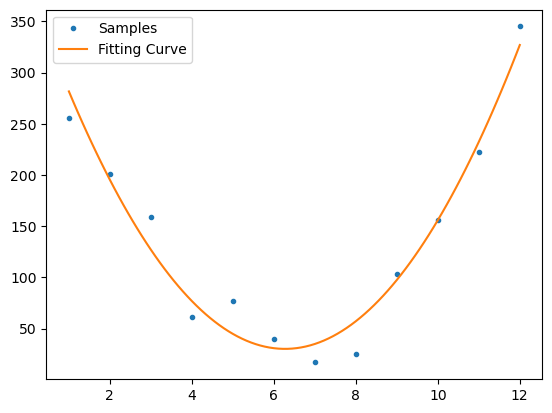

In [5]:
plt.plot(x,y,'.', label="Samples")
xh = np.linspace(1,12,100)
yh = a[0] + a[1]*xh + a[2]*xh**2
plt.plot(xh,yh, label="Fitting Curve")
plt.legend(loc='upper left')

这个方法由于正规方程组的条件数问题，不适用于高阶数的曲线拟合。而 QR 分解算法则很好地解决了这个问题。直接从 (2) 入手，对 $X$ 做 QR 分解，具体方法可以是 Householder 变换，也即将
$$
x = (x_1, x_2, \cdots, x_n)^T
$$
做正交变换为
$$
y = (*, 0, \cdots, 0)^T.
$$
这里的 Householder 变换矩阵定义为：
$$
H(w) = I - 2 ww^T,
$$
可以视为做以 $w = (y - x) / \|y - x\|_2$ 为法向量的镜面变换。如果是复向量则将转置变为共轭转置。显然这是一个正交变换。因此上面 $y$ 中的 $*$ 的值应该取为 $\|x\|_2$. 以 (2) 为例，我们先将第一列
$$
(1, 1, \cdots, 1)^T
$$
变换为
$$
(*, 0, \cdots, 0)^T.
$$
显然这里 $*$ 取 $\sqrt{12}$.

In [6]:
n = 12
X = np.array([np.ones(n), x, x**2])
X = X.T

xH = X[:,0]
yH = np.zeros(np.size(xH))
yH[0] = np.linalg.norm(xH)

w = yH - xH
w = w / np.linalg.norm(w)
H1 = np.eye(n) - 2 * np.dot(w.reshape(n,1),w.reshape(1,n))
X1 = np.dot(H1, X)
print(X1)

[[ 3.46410162e+00  2.25166605e+01  1.87638837e+02]
 [ 5.55111512e-17 -6.73205081e+00 -7.17431578e+01]
 [ 2.22044605e-16 -5.73205081e+00 -6.67431578e+01]
 [ 5.55111512e-17 -4.73205081e+00 -5.97431578e+01]
 [ 2.22044605e-16 -3.73205081e+00 -5.07431578e+01]
 [-1.66533454e-16 -2.73205081e+00 -3.97431578e+01]
 [ 0.00000000e+00 -1.73205081e+00 -2.67431578e+01]
 [-1.66533454e-16 -7.32050808e-01 -1.17431578e+01]
 [ 0.00000000e+00  2.67949192e-01  5.25684219e+00]
 [-1.11022302e-16  1.26794919e+00  2.42568422e+01]
 [ 0.00000000e+00  2.26794919e+00  4.52568422e+01]
 [-5.55111512e-17  3.26794919e+00  6.82568422e+01]]


对第二列, 我们只需将其消成
$$
(*, *, 0, \cdots, 0).
$$
也就是只需要一个右下角 $(n - 1) \times (n - 1)$ 是 Householder 阵就可以了。 

In [7]:
xH = X1[1:,1]
yH = np.zeros(np.size(xH))
yH[0] = np.linalg.norm(xH)

w = yH - xH
w = w / np.linalg.norm(w)
Hw = np.eye(n - 1) - 2 * np.dot(w.reshape(n - 1,1),w.reshape(1,n - 1))
H2 = np.eye(n)
H2[1:,1:] = Hw
X2 = np.dot(H2, X1)
print(X2)

[[ 3.46410162e+00  2.25166605e+01  1.87638837e+02]
 [-2.07649565e-16  1.19582607e+01  1.55457390e+02]
 [ 1.41336983e-16  8.88178420e-16  2.93599538e+00]
 [-1.11164100e-17  8.88178420e-16 -2.22006456e+00]
 [ 1.69497104e-16  1.33226763e-15 -5.37612450e+00]
 [-2.05000894e-16  7.77156117e-16 -6.53218444e+00]
 [-2.43873800e-17  0.00000000e+00 -5.68824437e+00]
 [-1.76840773e-16  1.38777878e-16 -2.84430431e+00]
 [ 3.77274082e-18 -2.77555756e-17  1.99963575e+00]
 [-9.31695012e-17  0.00000000e+00  8.84357581e+00]
 [ 3.19328617e-17 -4.44089210e-16  1.76875159e+01]
 [-9.49822916e-18 -2.22044605e-16  2.85314559e+01]]


同理消去第三列：

In [8]:
xH = X2[2:,2]
yH = np.zeros(np.size(xH))
yH[0] = np.linalg.norm(xH)

w = yH - xH
w = w / np.linalg.norm(w)
Hw = np.eye(n - 2) - 2 * np.dot(w.reshape(n - 2,1),w.reshape(1,n - 2))
H3 = np.eye(n)
H3[2:,2:] = Hw
X3 = np.dot(H3, X2)
print(X3)

[[ 3.46410162e+00  2.25166605e+01  1.87638837e+02]
 [-2.07649565e-16  1.19582607e+01  1.55457390e+02]
 [ 2.70064097e-17 -7.18346239e-16  3.65330900e+01]
 [-1.86712673e-17  7.82020774e-16  7.77156117e-16]
 [ 1.51202207e-16  1.07519550e-15  1.77635684e-15]
 [-2.27229852e-16  4.64804246e-16  1.55431223e-15]
 [-4.37444181e-17 -2.71996878e-16  8.88178420e-16]
 [-1.86519912e-16  2.77073040e-18  8.88178420e-16]
 [ 1.05774811e-17  6.78617441e-17 -4.44089210e-16]
 [-6.30749021e-17  4.22876524e-16 -3.10862447e-15]
 [ 9.21232994e-17  4.01681256e-16 -3.55271368e-15]
 [ 8.75940271e-17  1.14225454e-15 -9.76996262e-15]]


注意到:
$$
H3 * H2 * H1 * X = R.
$$
以及
$$
H3 * H2 * H1 
$$
是正交阵，因此令
$$
Q = (H3 * H2 * H1)^T,
$$
则有 
$$
X = QR.
$$
即完成了 QR 分解。

In [9]:
QT = np.dot(H3, np.dot(H2, H1))
Q = QT.T

检查 $Q$ 的正交性和 QR 分解：

In [10]:
np.linalg.norm(np.dot(Q,Q.T) - np.eye(n))

1.847339544250486e-15

In [11]:
R = X3
np.linalg.norm(np.dot(Q, R) - X)

1.4555709786825325e-13

In [12]:
X - np.dot(Q, R) 

array([[-2.22044605e-16,  4.44089210e-15,  5.68434189e-14],
       [ 0.00000000e+00,  7.99360578e-15,  7.81597009e-14],
       [ 0.00000000e+00,  1.77635684e-15,  4.97379915e-14],
       [ 0.00000000e+00,  1.33226763e-15,  2.13162821e-14],
       [ 0.00000000e+00,  0.00000000e+00,  2.48689958e-14],
       [ 2.22044605e-16,  0.00000000e+00,  7.10542736e-15],
       [ 0.00000000e+00, -8.88178420e-16, -7.10542736e-15],
       [ 2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       [ 1.11022302e-16, -1.77635684e-15, -2.84217094e-14],
       [ 2.22044605e-16, -1.77635684e-15, -2.84217094e-14],
       [ 1.11022302e-16, -3.55271368e-15, -5.68434189e-14],
       [ 1.11022302e-16, -3.55271368e-15, -5.68434189e-14]])

从这里我们看到，改进多项式的表示基也是有意义的。

继续我们的计算，注意我们实际上需要的是 $Q^T$, 上面缓存了。比如定理 5.60 中
$$ 
  \|Ax - b\|_2^2 = \|Q^T Ax - Q^T b\|_2^2 = \|R_1 x - c\|_2^2 + \|r\|_2^2, 
$$
我们已经有 $R_1$, 而 
$$
c = Q^T b.
$$
我们之前的记号和这里不一致，$A \to X$, $x -> a$, $b -> y$, 加上之前我们已经用掉了 $c$, 于是我们干脆用 $b$ 来记录课本上的 $c$:

In [13]:
b = np.dot(QT, y) 

而定理 5.60 的实际意义就是：
$$
\min \|Ax - b\| = \min \|R_1 x - c\|.
$$
也就是
$$
R_1 x = c
$$
的解。

In [14]:
aH = np.linalg.solve(R[0:3,:], b[0:3])
print(aH)

[ 386.         -113.42657343    9.04195804]


这个解和之前线性最小二乘的解是一致的。顺带还送了一个最小二乘解和原始数据之间的二范数误差：

In [15]:
r = np.linalg.norm(b[3:12])
print(r)

70.03305912659671


和之前的经典误差 (1) 比较：

In [16]:
np.linalg.norm(y - (a[0] + a[1]*x + a[2]*x**2))
#xh = np.linspace(1,12,100)
#yh = a[0] + a[1]*xh + a[2]*xh**2
#plt.plot(xh,yh, label="Fitting Curve")
#plt.legend(loc='upper left')

70.03305912659651

在解决离散最小二乘问题时，QR 分解算法的条件数是 $\text{cond} R_1$. 相比之下，基于正规方程的算法的条件数通常是 $(\text{cond} R_1)^2$. 然而这些都不如从一开始就选择一组合适的表示基。大家可以尝试一下用勒让德多项式来表达。